# <center>  Notebook S05. Size Distribution Inversion Using Regularization </center> 

<b> Notebook Version 2: This notebook has been updated to reflect changes made to the package <i> DifferentialMobilityAnalyzers.jl </i> to work with the Julia v1 series (tested with Julia 1.1.0). To read the original supplement published with the paper please switch to v1.0.0 of the package <i> DifferentialMobilityAnalyzers.jl </i> and/or download the virtual machine on zenodo.org which contains a complete installation that works with Julia 0.6.4 </b> 



This notebook demonstrates how to invert a size distribution from a measured noisy response function. The notebook is a supplement to the manuscript <br>

Petters, M. D. (2018) <i> A language to simplify computation of differential mobility analyzer response functions</i>, Aerosol Science & Technology. <br>

### Problem Statement

Let R be a measured response vector from a DMA. What is the measured true size distribution?

<img src="Figures/nbs2_f02.png" width="750" align = "middle">
<b> Figure 1. </b> Convolution of true size distribution resulting in the response vector.

For situations where instrument noise is neglible, $\epsilon_i \approx 0$ and 
<center> $ \rm{𝕣} = \bf{A}\rm{𝕟}$ </center><br>
In this case, the number concentration is readily obtained from a simple inversion
<center> $ \rm{𝕟} = \bf{A^{-1}}\rm{𝕣}$ </center><br>
This linear matrix inversion approach can be sufficient in some cases, However, even seemingly small noise  is amplified leading to unusable estimates of $\rm{𝕟}$ (e.g., Kandlikar and Ramachandran, 1999). Some method to dampen the noise is needed. This is a achieved via regularization. Several regularization approaches are available for this task (Kandlikar and Ramachandran, 1999). Here the Twomey inverse (Twomey, 1963) together with the L-curve method (Hansen, 2000) to find the optimal regularization parameter is applied. This Notebook demonstrates implementation of this approach using synthetic data. Application to actual data is presented in Notebook S6. <br>

Routines for regularization are contained in regularization.jl. The method reproduced below is taken from Hansen (2000). The inverse of 𝕣 is found as follows. The residual norm and size of the regularized system are defined as <br>
<center> $L_1 = \left\lVert \bf{A}\rm{𝕟} - \rm{𝕣}\right\rVert_2$ <br>
 $L_2 = \left\lVert \bf{L}(\rm{𝕟} - \rm{𝕟_i})\right\rVert_2$</center>
where $\left\lVert x \right\rVert_2$ denotes the 2-norm of a vector ($x$), $L_1$ and $L_2$ are the residual norm and size of the regularized system, $\bf{A}$ is the forward matrix, $\bf{L}$ is a weights matrix, and $𝕟_i$ is the initial guess of the correct solution. The general inverted size distribution $𝕟_{inv}$ is found via <br>
<center> $𝕟_{inv} = \arg \min\{L_1^2 + \lambda^2 L_2^2\}$ </center> <br>
where $\lambda$ is the regularization parameter and $\arg \min$ indicates the solution from a minimization algorithm. For the special case where $\bf{A}$ is square and $\bf{L} = \bf{I}$ equals the identity matrix, $𝕟_{inv}$ can be obtained without the need for computationally expensive minimization
<center> $𝕟_{inv} = (\bf{A}^\rm{T}\bf{A} + \lambda^\rm{2} \bf{I})^\rm{-1}(\bf{A}^\rm{T} \rm{𝕣} - \lambda^2\bf{S}^{-1} \rm{𝕣})$ </center><br>
 where the initial guess is taken to be $𝕟_i = \bf{S}^{-1}𝕣$ and $\bf{S}$ is obtained by summing the rows of $\bf{A}$ and placing the results on the diagonal of $\mathbf{S}$ (Talukdar and Swihart, 2010). The optimal $\lambda_{opt}$ is found using the L-curve method. The L-curve is defined as a plot of $\log(L_1)$ vs.  $\log(L_2)$, where $L_1$ and $L_2$ are obtained for a series of discrete $\lambda$ values. The $\lambda_{opt}$ is found at the corner of the L-curve, which is mathematically defined as the point where where the curvature of the L-curve is maximum. Here the corner of the L-curve is found using the iterative algorithm described in Talukdar and Swihart (2010). The curvature is calculated using Eq. (14) in Hansen (2000), which requires the first and second derivatives of $d\ln(L_i)^2/d\lambda$. These derivatives of $d\ln(L_i)^2/d\lambda$ are estimated using the Calculus.jl package and defined in regularization.jl<br>
        
## Block 1. Dependencies

In [1]:
using Plots, Plots.PlotMeasures, Distributions, DifferentialMobilityAnalyzers, Random, LinearAlgebra, Printf
plotlyjs();    

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/2b173c803613f398a23fcc9b3acf1ad072d0a466-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

## Block 2. Setup the DMA 


In [2]:
t,p = 295.15, 1e5                                # Temperature [K], Pressure [Pa]
qsa,β = 1.66e-5, 1/5                             # Qsample [m3 s-1], Sample-to-sheath ratio,
r₁,r₂,l = 9.37e-3,1.961e-2,0.44369               # DMA geometry [m]
leff = 13.0                                      # DMA effective diffusion length [m]
m = 3                                            # Upper number of charges
Λ = DMAconfig(t,p,qsa,qsa/β,r₁,r₂,l,leff,:-,m,:cylindrical)   # Specify DMA with negative polarity
bins,z₁,z₂ = 128, dtoz(Λ,1000e-9), dtoz(Λ,10e-9) # bins, upper, lower mobility limit
δ = setupDMA(Λ, z₁, z₂, bins);                   # Compute matrices

## Block 3. Size distribution and response function
The example provided here is for an assumed size distribution. From that distribution, the response function is computed and Poisson counting noise superimposed. The inversion algorithm is then applied and the result compared to the original input distribution.

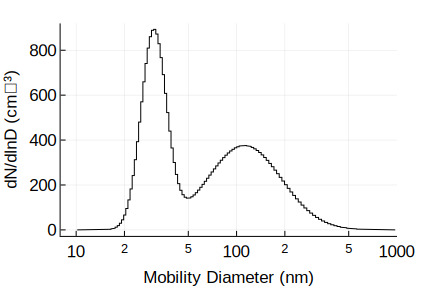

In [3]:
figure("Nimbus Sans L", 2, 3, 2, 8)
𝕟 = DMALognormalDistribution([[400, 30, 1.2],[500, 110, 1.7]], δ)
p = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, right_margin = 35px,
    legend = :none, ylabel = "dN/dlnD (cm⁻³)", xlim = (8,1000), color =  :black,
    xlabel = "Mobility Diameter (nm)", fmt = :svg)

<b> Figure 2.</b> Lognormal aerosol size distribution 𝕟, represented as dN/dlnD. This is the assumed mobility size distribution from which the response vector is computed.

The response size distribution 𝕣 is computed as <br>
<center> $\rm{𝕣} = \bf{A}\rm{𝕟}$ </center> <br>
where $\bf{A}$ is the forward matrix defined in module DifferentialMobilityAnalyzer.jl. The convolution is applied to the dN/dlnD and N fields of the size distribution. The resulting 𝕣 distribution is what an ideal instrument would measure. In practice, counting uncertainty imposes noise on the response. Counting uncertainty is simulated using a Poisson process. The actual number of counts in each bin are <br>
<center> $c_i = N_iQ_{CPC}t$ </center> <br>
where $N$ is the number concentration in the bin, $Q_{CPC}$ is the flow rate of the CPC and $t$ is the integration time over the bin. The integration time is the ratio of scan time and number of bins. The noisy response function is obtained by computing the expected number of counts in a bin ($c_i$)  followed by drawing a random number from a Poisson distribution with expectation value $c_i$, i.e. $c_\epsilon = P(\mu=c_i)$, where $\mu$ is the mean of the Poisson distribution, and $c_\epsilon$ are the noisy counts. The noise perturbed count distribution is then converted back to concentration and denoted as <br>
<center> $\rm{𝕣} = \bf{A}\rm{𝕟+ϵ}$ </center> <br>
The noise level of the distribution depends on scan rate, CPC flow rate and number concentration of the parent size distribution.

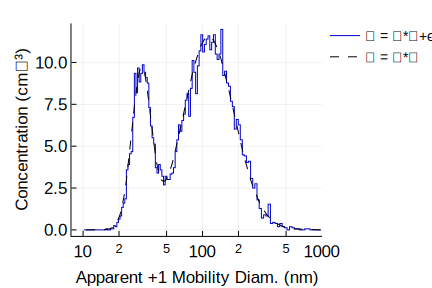

In [4]:
Random.seed!(703)  # random number seed; fix for repeatable runs
tscan = 120        # SMPS scan time [s] 
Qcpc = 16.66       # CPC flow rate [cm³ s⁻¹]. 16.66 cm³ s⁻¹ = 1 L min⁻¹
t = tscan./bins    # time in each bin

𝕣 = δ.𝐀*𝕟;      # DMA response function 
c = 𝕣.N*Qcpc*t; # number of counts in each bin
R = Float64[]   # Construct a noisy response function 𝕣+ϵ, where ϵ is counting uncertainty
for i = c
    f = rand(Poisson(i),1)   # draw Poisson random number with mean = counts
    push!(R,f[1]/(Qcpc*t))   # convert back to concentration
end

p = plot(𝕣.Dp, R, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre, label = "𝕣 = 𝐀*𝕟+ϵ", 
    ylabel = "Concentration (cm⁻³)", xlim = (8,1000), color =  color = RGBA(0,0,0.8,1),
    xlabel = "Apparent +1 Mobility Diam. (nm)", left_margin = 25px)
p = plot!(𝕣.Dp, 𝕣.N, label = "𝕣 = 𝐀*𝕟", color = :black, ls = :dash, fmt = :svg)

<b> Figure 2.</b> Response function for system with no noise (𝕣 = A𝕟) and system with counting uncertainty (𝕣 = A𝕟+ϵ) represented as measured concentration. The counting uncertainty depends on the total number concentration, the CPC flow rate and the time spent in each bin, which is determined by the scan rate. 

## Block 4. Inversion using regularization
The matrices $\bf{A}$ and $\bf{S}$ are defined in the module DifferentialMobilityAnalyzer.jl. The identity matrix is $\mathbf{I}$ = eye(n), where n is the number of bins. Calculations can be performed on either the number concentration or dN/dlnD vectors. Here calculations are performed on the number concentration vector R and the dN/dlnD and resulting 𝕟ᵢₙᵥ is assembled manually at the end of the computation. This is to avoid unnecessary complexity of the code in regularization.jl. <br><br>
<b>setupRegularization(A,I,R,Ni)</b> defines the system of equations in terms of the matrices A, and I, the response R and the initial guess Ni. <br><br>
<b>lcurve(λ₁,λ₂;n=200)</b> computes the L₁ and L₂ over the interval [λ₁,λ₂] for n=200 points. The function discretizes [λ₁,λ₂] in logspace and returns the array of λ-values (λs) and index where the curvature is maximum (ii). The function is only used for smooth visulation of the L-curve and not needed in the actual inversion.  <br>

<b>lcorner(λ₁,λ₂;n=10,r=3)</b> computes the L₁ and L₂ over the interval [λ₁,λ₂] for n=10 points calling lcurve(). The grid is recursively adapted three times to zoom into the optimal value, resulting in 30 total inversions. The optimal lambda value (λopt) is returned <br>

<b>(reginv(λopt, r = :Nλ))[1]</b> return the inverted number vector for λopt. reginv() returns a vector of inversions so the first element is extracted. For low number concentration, the inversion can return negative numbers. The clean function zeros negative values in the vector. <br>

Finally, the regularized size distribution 𝕟ᵢₙᵥ is reconstructed and actual vs. inverted number concentration are compared. The time required to compute lcurve and lcorner is reported. For n = 128 bins, λopt can be obtained within ~0.5s

In [5]:
λ₁,λ₂ = 1e-3, 1e1  # bounds [λ₁,λ₂] within which the optimal distribution lies

eyeM = Matrix{Float64}(I, bins, bins)
setupRegularization(δ.𝐀,eyeM,R,inv(δ.𝐒)*R)   # setup the system of equations to regularize
@time L1,L2,λs,ii = lcurve(λ₁,λ₂;n=200)      # compute the L-curve for plotting only
@time λopt = lcorner(λ₁,λ₂;n=10,r=3)         # compute the optimal λ using recursive algorithn
N =  clean((reginv(λopt, r = :Nλ))[1])       # find the inverted size distribution 
𝕟ᵢₙᵥ= SizeDistribution([],𝕟.De,𝕟.Dp,𝕟.ΔlnD,N./𝕟.ΔlnD,N,:regularized) # store as AerosolSizeDistribution

@printf("Input number concentration %i\n", sum(𝕟.N))
@printf("Inverted number concentration %i\n", sum(𝕟ᵢₙᵥ.N))

  8.032454 seconds (4.28 M allocations: 2.109 GiB, 4.14% gc time)
  1.515819 seconds (113.09 k allocations: 394.505 MiB, 3.58% gc time)
Input number concentration 900
Inverted number concentration 894


## Block 5. Visualization

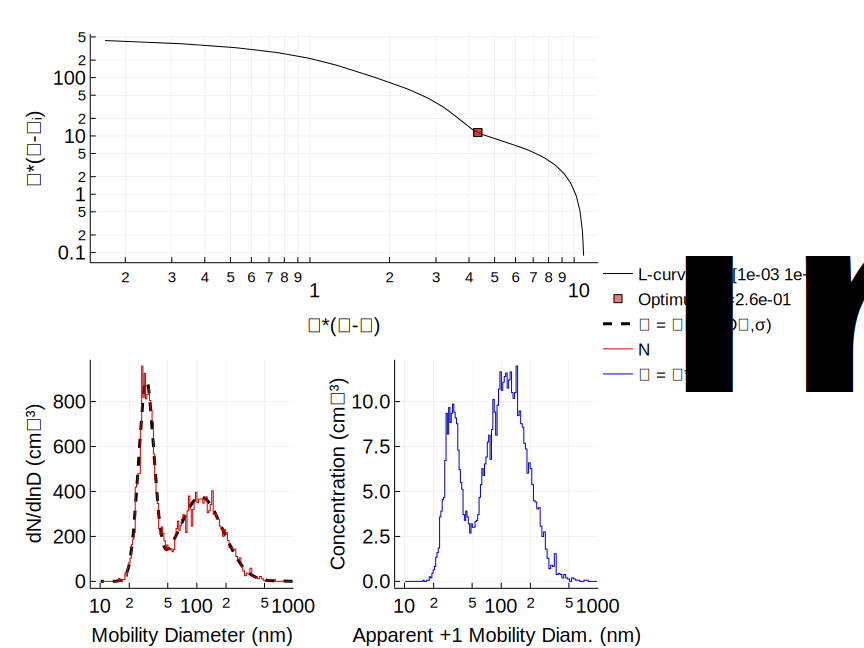

In [6]:
figure("Nimbus Sans L", 2, 6, 4.5, 10)

p1 = plot(L1, L2, xaxis = :log10, yaxis = :log10, xlabel = "𝐀*(𝕟-𝕣)", ylabel = "𝐈*(𝕟-𝕟ᵢ)", color = :black, 
    label = "L-curve"*(@sprintf(" λ ∈ [%.0e %.0e]", λ₁,λ₂)), bottom_margin = 50px)

p1 = plot!([L1[ii], L1[ii]], [L2[ii], L2[ii]], marker = :square, color = RGBA(0.8,0,0,0.5), 
            label = "Optimum λ ="*(@sprintf("%.1e", λopt)),lw = 0, ms = 4)

p2 = plot(𝕟.Dp, 𝕟.S, xaxis = :log10, xticks = [10, 100, 1000],left_margin = 65px, ylabel = "dN/dlnD (cm⁻³)", 
    label = "𝕟 = 𝓛𝓝 (N,Dₘ,σ)", xlabel = "Mobility Diameter (nm)", xlim = (8,1000), ls = :dash, 
    lw = 3, color = :black)

p2 = plot!(𝕟ᵢₙᵥ.Dp, 𝕟ᵢₙᵥ.S, color = RGBA(0.8,0,0,1), lt = :steppre, 
    label = "N<sub>inv</sub>=(𝐀ᵀ𝐀+λ²𝐈)⁻¹(𝐀ᵀR-λ²𝐒⁻¹R)", xlim = (8,1000))

p3 = plot(𝕣.Dp, R, xaxis = :log10, xticks = [10, 100, 1000], lt = :steppre,
    label = "𝕣 = 𝐀*𝕟+ϵ", ylabel = "Concentration (cm⁻³)", xlim = (8,1000),
    color = RGBA(0,0,0.8,1), xlabel = "Apparent +1 Mobility Diam. (nm)", left_margin = 65px)

plot(p1,p2,p3, layout = (l = @layout [a; b c]), right_margin = 0px, legend=:right, 
    top_margin = 15px, fmt = :svg)

<b> Figure 3.</b> Top: L-curve of $L_1$ vs. $L_2$ as defined in Block 4. The L-curve is computed from the interval [λ₁,λ₂] using the lcurve() function. The optimum $\lambda_{opt}$ is determined from the interative algorithm lcorner(). Bottom left: dashed line is the input size distribution (as in Figure 1). Red line is the regularized inverse of the noisy response function shown in the bottom right (as in Figure 2). 

## Summary and Conclusions
Figure 3 shows that the algorithm is able to correctly invert noisy data. This notebook can be used to test the algorithm over a wide range of conditions, including DMA flow ratios, input aerosol size distribution, scan rates, and bin density. Semi-systematic testing with this notebook can be used to convince oneself that the method is robust. The optimum regularization parameter $\lambda_{opt}$ (and thus solution) can be found within ~0.5-1s for a 128 bin grid (depending on computer speed and number of processes running).  

## References

Hansen, P. C. (2000) The L-Curve and its Use in the Numerical Treatment of Inverse Problems, in Computational Inverse Problems in Electrocardiology, ed. P. Johnston, Advances in Computational Bioengineering, 119-142, WIT Press. <br> 

Kandlikar, M., & Ramachandran, G. (1999) Inverse methods for analysing aerosol spectrometer measurements: A critical review. Journal of Aerosol Science, 30(4), 413-437, DOI: 10.1016/S0021-8502(98)00066-4. <br>

Reineking, A. & J. Porstendörfer (1986) Measurements of Particle Loss Functions in a Differential Mobility Analyzer (TSI, Model 3071) for Different Flow Rates, Aerosol Science and Technology, 5:4, 483-486, DOI: 10.1080/02786828608959112. <br> 

Talukdar, Suddha S. & Mark T. Swihart (2010) An Improved Data Inversion Program for Obtaining Aerosol Size Distributions from Scanning Differential Mobility Analyzer Data, Aerosol Science and Technology, 37:2, 145-161, DOI: 10.1080/02786820300952. <br>

Twomey, S. (1963) On the numerical solution of Fredholm integral equations of the first kind by inversion of the linear system produced by quadrature, Journal of the ACM, 19(1963), 97–101, DOI:0.1145/321150.321157. <br>